# Notes/ To Do
- switch to simple neural net work instead
- more comments

# Using simple Deep Neural Network to predict Count of total rental bikes

### Cleanning Data/Preprocessing
During EDA, there weren't any Na's in the data set, but there were categorical data that should be converted to dummies. The 'cleanningData' function will get dummies for the categorical features. The categorical features are actually type 'int64' in this data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to classify features
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification

# split data, need to redo this part with stratified split!!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ConvNets
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
dailyData = pd.read_csv('C:/Users/Jenny/Desktop/UOP-MSDS/2020Spring/ANLT_210_SoftwareMethods/Bikeshare/Data/daily.csv')
hourlyData = pd.read_csv('C:/Users/Jenny/Desktop/UOP-MSDS/2020Spring/ANLT_210_SoftwareMethods/Bikeshare/Data/hourly.csv')

In [3]:
dailyData.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
dailyData.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Same as in the EDA phase, we will remove features that aren't needed and repeative.

In [5]:
dailyData2 = dailyData.drop(['instant', 'dteday', 'casual', 'registered'], axis = 1)

In [6]:
def cleaningData(df):
    # taking out 'cnt', we don't want to get dummies for 'cnt'
    dataset = df.drop(['cnt'], axis = 1)
    
    # making a list of possible categorical features
    possibleCate = []
    for i in range(len(dataset.columns)):
        if dataset.dtypes[i] == 'int64':
            possibleCate.append(dataset.columns[i])
            
    #get dummies for categorical features
    for cat in possibleCate:
        dataset = pd.concat([dataset, pd.get_dummies(dataset[cat], prefix = cat, dummy_na = False)], axis = 1)
        dataset = dataset.drop(cat, axis = 1)
    
    # adding 'cnt' back into the data set
    dataset = pd.concat([dataset, df['cnt']], axis = 1)
    
    return dataset
    #print(possibleCate)

In [7]:
dailyCate = cleaningData(dailyData2)

In [8]:
dailyCate.head()

,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,yr_0,yr_1,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,cnt
0,0.344167,0.363625,0.805833,0.160446,1,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,985
1,0.363478,0.353739,0.696087,0.248539,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,801
2,0.196364,0.189405,0.437273,0.248309,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1349
3,0.200000,0.212122,0.590435,0.160296,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1562
4,0.226957,0.229270,0.436957,0.186900,1,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,1600


In [9]:
dailyCate.shape

(731, 37)

### Feature selection

Using sklearn's ExtraTreesClassifier to determine which features to extract.

In [22]:
def featureSelect(dataset, n):
    # splitting X (features) and y (output) to be used in ExtraTreesClassifier
    X = dataset.drop(['cnt'], axis = 1)
    y = dataset['cnt']

    # bulid the model
    extra_tree_forest = ExtraTreesClassifier(n_estimators = 100,
                                             criterion = 'gini')

    # train the model
    extra_tree_forest.fit(X, y)

    # compute importance of each feature
    feature_importance = extra_tree_forest.feature_importances_

    # Normalizing the individual importances 
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                            extra_tree_forest.estimators_], 
                                            axis = 0)

    # sort orderFeat from greatest to least
    orderFeat = np.argsort(-feature_importance_normalized)

    # top n features
    featUsed = []
    for i in range(n):
        featUsed.append(X.columns[orderFeat[i]])
        
    xFeat = pd.DataFrame(dataset[featUsed])

    return xFeat, y

In [23]:
xfeat, y =  featureSelect(dailyCate, 10)

In [24]:
xfeat.head()

,atemp,windspeed,hum,temp,yr_0,yr_1,weekday_4,weekday_3,weathersit_2,weekday_6
0,0.363625,0.160446,0.805833,0.344167,1,0,0,0,1,1
1,0.353739,0.248539,0.696087,0.363478,1,0,0,0,1,0
2,0.189405,0.248309,0.437273,0.196364,1,0,0,0,0,0
3,0.212122,0.160296,0.590435,0.200000,1,0,0,0,0,0
4,0.229270,0.186900,0.436957,0.226957,1,0,0,1,0,0


### Split and normalize the data
The split will be 80% for train and 20% for test. The data set is normalized using StandardScaler from sklearns.

In [25]:
def splitData(x, y):
    # split data to X_train, X_test, y_train, y_test:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
    
    return X_train, X_test, y_train, y_test

In [26]:
dailyX_train, dailyX_test, dailyy_train, dailyy_test = splitData(xfeat, y)

In [28]:
# normalize
sc = MinMaxScaler(feature_range=(0, 1))
dailyX_train = sc.fit_transform(dailyX_train)
dailyX_test = sc.transform(dailyX_test)

### Simple Deep Neural Net

In [39]:
def deepNNModel(xtrain, ytrain, xtest):
    model = Sequential()
    model.add(Dense(10, activation = 'relu', input_dim = len(xtrain[1])))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'linear'))
    
    #print summary
    model.summary()
    
    # loss funtcion
    model.compile(loss = 'mean_squared_error',
                  optimizer = 'RMSprop',
                  metrics = ['accuracy', 'mse'])

    # fit the model
    model.fit(xtrain,
              ytrain,
              batch_size = 100,
              epochs = 50,
              validation_split = 1/6,
              verbose = 1)

    # predict 'Flag'
    yprobability = model.predict(xtest)
    
    return yprobability, model

In [40]:
y_pred, model = deepNNModel(dailyX_train, dailyy_train, dailyX_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Train on 486 samples, validate on 98 samples
Epoch 1/50
486/486 [==============================] - 1s 2ms/step - loss: 236

486/486 [==============================] - 0s 37us/step - loss: 23588251.1770 - accuracy: 0.0000e+00 - mse: 23588250.0000 - val_loss: 24991618.0000 - val_accuracy: 0.0000e+00 - val_mse: 24991618.0000
Epoch 35/50
486/486 [==============================] - 0s 39us/step - loss: 23587830.0741 - accuracy: 0.0000e+00 - mse: 23587832.0000 - val_loss: 24991286.0000 - val_accuracy: 0.0000e+00 - val_mse: 24991286.0000
Epoch 36/50
486/486 [==============================] - 0s 39us/step - loss: 23587619.6461 - accuracy: 0.0000e+00 - mse: 23587620.0000 - val_loss: 24990944.0000 - val_accuracy: 0.0000e+00 - val_mse: 24990944.0000
Epoch 37/50
486/486 [==============================] - 0s 39us/step - loss: 23587386.1481 - accuracy: 0.0000e+00 - mse: 23587384.0000 - val_loss: 24990594.0000 - val_accuracy: 0.0000e+00 - val_mse: 24990594.0000
Epoch 38/50
486/486 [==============================] - 0s 37us/step - loss: 23587048.9136 - accuracy: 0.0000e+00 - mse: 23587048.0000 - val_loss: 24990240.0000 - va

### Plotting true values (y) and predictions (y_pred)

In [31]:
y_pred.shape

(147, 1)

In [32]:
dailyy_test.shape

(147,)

In [33]:
type(dailyy_test)

pandas.core.series.Series

ValueError: non-broadcastable output operand with shape (147,1) doesn't match the broadcast shape (147,10)

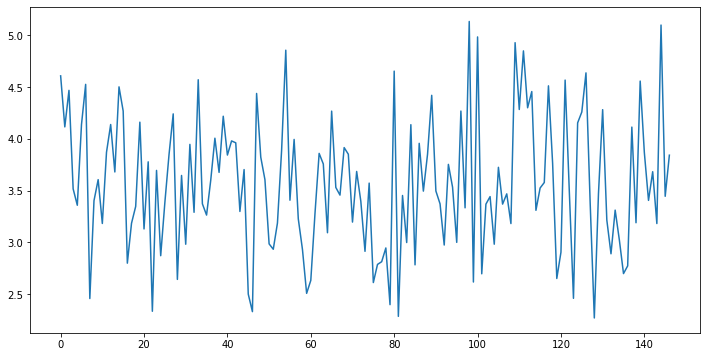

In [34]:
plt.figure(figsize = (12,6))
#plt.plot(y_pred, label = "Predictions")
#plt.plot(dailyy_test, label = "True")
plt.plot(y_pred, label = "Predictions")
#plt.plot(dailyy_test, label = "True")
plt.plot(sc.inverse_transform(np.array(dailyy_test).reshape(-1, 1)), label = "True")
plt.legend()
plt.show()

In [41]:
print('The mean squared error is %.3f' % model.evaluate(dailyX_test, dailyy_test)[1])

147/147 [==============================] - 0s 54us/step
The mean squared error is 0.000


# Using Naive Bayes to predict Count of total rental bikes

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


In [2]:
# turns category data to numeric
def categoryToNum(dataSet):
    # import data
    d = dataSet
    # get column names of non numeric columns
    stringCol = d.select_dtypes(include='dtype').columns.values
    #setting dtype to category and converting category to numeric values
    for colName in stringCol:
        d[colName] = d[colName].astype('category')
        d[colName] = d[colName].cat.codes
    # run correlations and sort according to best
    dataCorr = abs(d.corr(method = 'pearson')['cnt'])
    dataCorr = dataCorr.drop(['cnt'])
    sortCorr = (dataCorr[~np.isnan(dataCorr)]).sort_values(ascending = False)
    return d, sortCorr

In [3]:
# select x factors to predict y with at least 0.80 accuracy
def selectXFeats(n):
    #n = number of features
    newData = pd.DataFrame()
    newData['cnt'] = d['cnt']
    for feat in range(n):
        newData[sortCorr.index[feat]] = d[sortCorr.index[feat]]
    return newData

In [11]:
# this one starts the thing
def dataSet(data, testProportion):
    x = data.drop(['cnt'], axis = 1)
    y = data['cnt']
    nbGaus(x, y, testProportion)

In [5]:
# function to get yTest (prediction) values
def nbGaus(x, y, testProportion = 0.8):
    XTrain, XTest, yTrain, yTest = train_test_split(x, y, test_size=testProportion)
    gausNB = GaussianNB()
    yPred = gausNB.fit(XTrain, yTrain).predict(XTrain)
    accuracyRate = accuracy(yPred, yTrain)
    if accuracyRate > 0.8:
        print('Train: \nAccuracy Rate:', accuracyRate *100, '% \nFactors used:', list(x.columns))
    else:
        #add next feat to xData
        data = selectXFeats(xdata.shape[1])
        dataSet(data, 0.8)

In [6]:
# function to get accuracy
def accuracy(yPred, yTrain):
    #accuracies = ((predictions == (df['passing'].values)).sum(axis=0)/len(df['passing']))
    #accuracy = (fit.predict(Xs) == y).sum()/y.shape[0]
    accuracyRate = ((yPred == yTrain).sum(axis=0)/len(yTrain))
    return accuracyRate

# Daily Data

In [7]:
dailyData = pd.read_csv('C:/Users/Jenny/Desktop/UOP-MSDS/2020Spring/ANLT_210_SoftwareMethods/Bikeshare/Data/daily.csv')

In [8]:
dailyData.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [14]:
dailyData.drop(['casual', 'registered'], axis = 1).head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [15]:
dailyData2 = dailyData.drop(['casual', 'registered'], axis = 1)

In [18]:
# getting categorical data to numeric
d, sortCorr = categoryToNum(dailyData2)
# starting data with one X feature
xdata = selectXFeats(1)

In [22]:
# runs everything
dataSet(xdata, 0.8)

Train: 
Accuracy Rate: 98.63013698630137 % 
Factors used: ['atemp']


# Hourly Data

In [23]:
hourlyData = pd.read_csv('C:/Users/Jenny/Desktop/UOP-MSDS/2020Spring/ANLT_210_SoftwareMethods/Bikeshare/Data/hourly.csv')

In [24]:
hourlyData2 = hourlyData.drop(['casual', 'registered'], axis = 1)

In [25]:
# getting categorical data to numeric
d2, sortCorr2 = categoryToNum(hourlyData2)
# starting data with one X feature
xdata2 = selectXFeats(1)

In [26]:
# runs everything
dataSet(xdata2, 0.8)

Train: 
Accuracy Rate: 98.63013698630137 % 
Factors used: ['atemp']


## What Naive Bayes tells Us
After runing Naive Bayes on both Daily and Hourly data set, 'atemp' shows that it predicts counts for total bike rentals with an accuracy rate of over 95%.

<font color = 'red'> Need to predict count of total bike rentals </font>